# PROJET D'OPTIMISATION - GRP 4 

## Restauration d'images 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

#Paramètres 
n_max = 10000
l = 0.1


# Partie 1

### Question 1 - 3

_(Réponses aux questions théoriques)_

### Question 4

[[0.20392157 0.20392157 0.20392157 ... 0.34509804 0.34509804 0.35294118]
 [0.2        0.2        0.20784314 ... 0.34509804 0.34509804 0.35294118]
 [0.19607843 0.20392157 0.21176471 ... 0.35294118 0.35294118 0.36078431]
 ...
 [0.18823529 0.17647059 0.19215686 ... 0.07058824 0.0745098  0.0745098 ]
 [0.18823529 0.17647059 0.19215686 ... 0.0745098  0.0745098  0.0745098 ]
 [0.18431373 0.17647059 0.18823529 ... 0.0745098  0.0745098  0.0745098 ]]
1197431209984


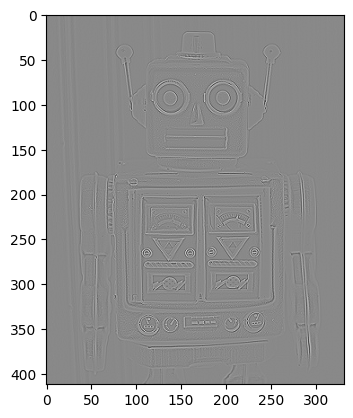

In [3]:
def grad(u):
    """Computes the discrete gradient of a (n x m) matrix."""
    
    (n, m) = u.shape
    grad = np.zeros((n,m,2))

    grad[:n-1,:,0] = u[1:n, :] - u[0:n-1, :]
    grad[:,:m-1,1] = u[:, 1:m] - u[:, 0:m-1]

    return grad

def div(v):
    """Computes the discrete divergence of a vector of size (n x m x 2)."""
    
    (n, m) = v.shape[:2]  # v is a vector of size n x m x 2
    v_x = v[:, :, 0]
    v_y = v[:, :, 1]
    div = np.zeros((n, m))
    
    div[0, :] += v_x[0, :]
    div[n-1, :] += -v_x[n-2, :]
    div[1:n-1, :] += (v_x[1:n-1, :] - v_x[0:n-2, :])
    
    div[:, 0] += v_y[:, 0]
    div[:, m-1] += -v_y[:, m-2]
    div[:, 1:m-1] += (v_y[:, 1:m-1] - v_y[:, 0:m-2])
    
    return div

def display(image):
    # Rescaling values from 0 to 1
    image = (image - np.min(image))/(np.max(image) - np.min(image))
    (n, m) = image.shape[:2]

    # Copying each value to a tuple
    gray_im = np.zeros((n,m,3))
    gray_im[:,:,0] = image
    gray_im[:,:,1] = image
    gray_im[:,:,2] = image

    plt.imshow(gray_im)


u = plt.imread("./robot_no_noise.jpg")
u = u[:,:,0]/255

laplacian = div(grad(u))  
display(laplacian)
print(u)
(n, m) = u.shape
print(((n*m)**2)*64)

On peut discerner les contours du robots ce qui est cohérent car c'est à ces endroits que les variations de couleurs sont élevées et donc que le laplacien le sera également. 

### Question 5 
_Algorithme de descente de gradient à pas fixe_

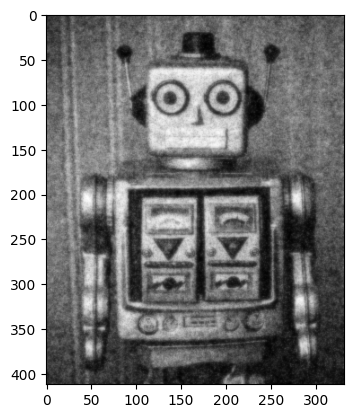

In [4]:
u_b = plt.imread("./robot_noise.jpg")[:,:,0]/255

def grad_f(u: np.ndarray) -> np.ndarray:
    """Returns the gradient of function f at matrix u."""
    return (u - u_b - 2*div(grad(u)))

def grad_descent(z0: np.ndarray, step: float, eps: float=1e-8) -> np.ndarray:
    """Implements the gradient descent algorithm with a constant step."""
    z = z0
    n = 0
    
    while np.linalg.norm(grad_f(z), ord='fro') >= eps and n <= n_max:
        z = z - step * grad_f(z)
    
    return z

# Restoration
u_rest_1 = grad_descent(u_b, l)
display(u_rest_1)


### Question 6

_Quantification de l'écart_

In [5]:
def RMSE(z: np.ndarray) -> float:
    (n, m) = u.shape
    return (np.sqrt(np.linalg.norm(u - z, ord='fro') / (n * m)))  # Frobenius norm

print(f"RMSE de l'image restaurée V1 : {RMSE(u_rest_1)}")
print(f"RMSE de l'image bruitée : {RMSE(u_b)}")


RMSE de l'image restaurée V1 : 0.01615111641021221
RMSE de l'image bruitée : 0.02238260721925278


On remarque que RMSE(signal dénoisé) < RMSE(signal bruité). C'est le résultat escompté ! 

On restaure donc légèrement l'image bruitée, mais c'est encore insatisfaisant.

### Question 7

_Comparaison à la bibliothèque Scipy_

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 2535.7832873341513
        x: [ 2.589e-01  2.474e-01 ...  9.021e-02  1.039e-01]
      nit: 22
      jac: [-2.449e-05 -1.132e-06 ...  3.049e-06 -1.064e-05]
     nfev: 27
     njev: 27
 hess_inv: <136784x136784 LbfgsInvHessProduct with dtype=float64>


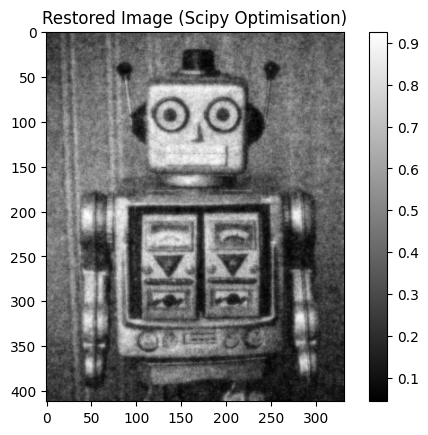

In [6]:
# Flattening the arrays
u_b2 = u_b.flatten()  # Flattening to a 1D array
u2 = u.flatten()

# Defining the function f_2
def f_2(x):
  g = grad(x.reshape((n, m)))
  return 0.5 * np.sum((x - u_b2)**2) + np.linalg.norm(g)**2

# Defining the gradient of f_2
def grad_f_2(x):
  g = grad(x.reshape((n, m)))
  return (x - u_b2) - 2 * div(g).flatten()

# Using scipy.optimize.minimize with bounds and gradient
result = scipy.optimize.minimize(
  f_2,
  u_b2,
  method='L-BFGS-B',
  jac=grad_f_2,
)

print(result)
# Reshaping the result
u_rest_2 = result.x.reshape((n, m))

# Displaying the restored image
plt.imshow(u_rest_2, cmap='gray')
plt.title('Restored Image (Scipy Optimisation)')
plt.colorbar()
plt.show()


In [7]:
print(f"RMSE de l'image restaurée V2 : {RMSE(u_rest_2)}")

RMSE de l'image restaurée V2 : 0.016151121615624424


## Bilan 

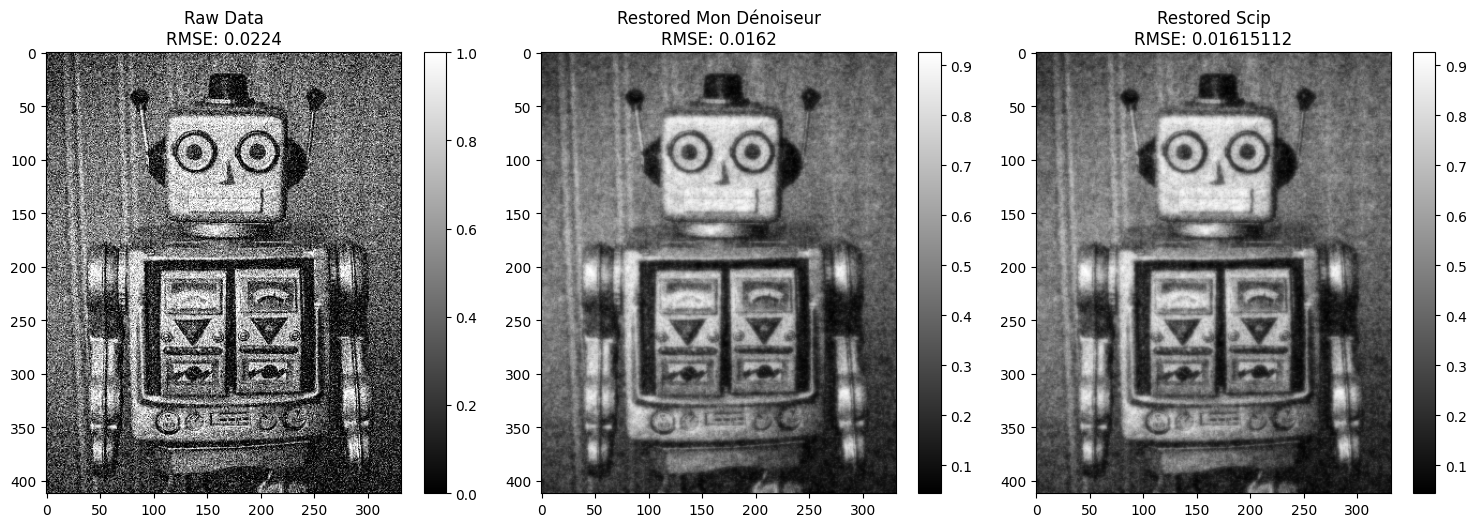

In [8]:
# Display the raw data
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(u_b, cmap='gray')
plt.title(f'Raw Data\nRMSE: {RMSE(u_b):.4f}')
plt.colorbar()

# Display the first result
plt.subplot(1, 3, 2)
plt.imshow(u_rest_1, cmap='gray')
plt.title(f'Restored Mon Dénoiseur\nRMSE: {RMSE(u_rest_1):.4f}')
plt.colorbar()

# Display the second result
plt.subplot(1, 3, 3)
plt.imshow(u_rest_2, cmap='gray')
plt.title(f'Restored Scip\nRMSE: {RMSE(u_rest_2):.8f}')
plt.colorbar()

plt.tight_layout()
plt.show()

On a des résultats similaires avec les deux méthodes. La RMSE est également similaire. Dans les 2 cas, les détails sont assez bien conservés. 

# Partie 2 

## Question 8 - 9 
_(Réponses aux questions théoriques)_

## Question 10


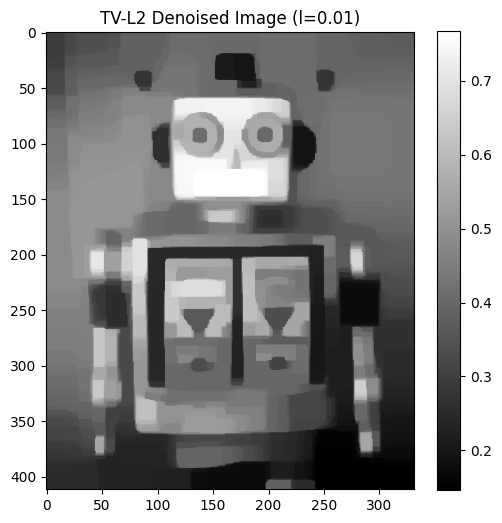

RMSE de l'image restaurée V3 : 0.019494784958279176
RMSE de l'image bruitée : 0.02238260721925278


In [9]:
def subgradient_tv_l2(u, u_b):
    sig_grad = np.sign(grad(u))
    div_sig_grad = div(sig_grad) 
    return u - u_b - div_sig_grad

def optim_gradient_fixed_step_2(grad_fun, x0, l, max_iter = 100, epsilon_grad_fun = 1e-8):
    L_x = [x0]
    x_k = x0
    counter = 0 
    for k in range(max_iter):
        counter += 1 
        x_k = x_k - l/(k+1) * grad_fun(x_k,x0)
        L_x.append(x_k)
        if np.linalg.norm(grad_fun(x_k,x0)) < epsilon_grad_fun: 
            break
    return x_k, L_x, counter

u_rest_3 = optim_gradient_fixed_step_2(subgradient_tv_l2,u_b, l, n_max, 1e-8)[0]
# Display the first restored image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(u_rest_3, cmap='gray')
plt.title('TV-L2 Denoised Image (l=0.01)')
plt.colorbar()

plt.tight_layout()
plt.show()

print(f"RMSE de l'image restaurée V3 : {RMSE(u_rest_3)}")
print(f"RMSE de l'image bruitée : {RMSE(u_b)}")


La RMSE obtenue avec cette méthode est plus élevée que la précédente ce qui indique une meilleure restauration en revanche au delà l'image devient flou et la RMSE devient supérieur à la précédente. Visuellement, il semblerait que l'homogénéité des couleurs prime sur les détails. 

## Question 11

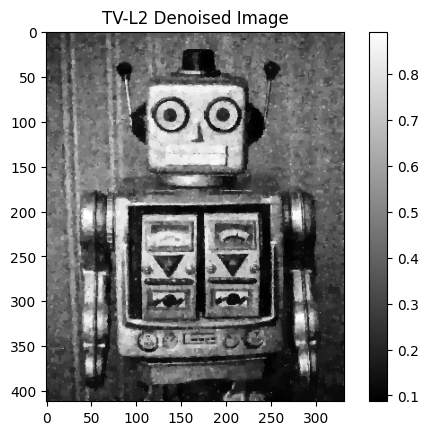

RMSE de l'image restaurée V4 : 0.014672082907462433


In [10]:
def subgradient_tv_l2(u, u_b):
    sig_grad = np.sign(grad(u))
    div_sig_grad = div(sig_grad) 
    return u - u_b - div_sig_grad

def optim_gradient_fixed_step_3(grad_fun, x0, l, beta = 0, max_iter = 100, epsilon_grad_fun = 1e-8):
    L_x = [x0]
    x_k = x0
    counter = 0
    p_k = 0 
    for k in range(max_iter):
        counter += 1 
        p_k = (beta * p_k + (1-beta) * (-grad_fun(x_k,x0)))/(k+1)
        x_k = x_k + l * p_k
        L_x.append(x_k)
        if np.linalg.norm(grad_fun(x_k,x0)) < epsilon_grad_fun: 
            break
        
    return x_k, L_x, counter

u_rest_4 = optim_gradient_fixed_step_3(subgradient_tv_l2,u_b, l, 0.9, n_max, 1e-8)[0]

plt.imshow(u_rest_4, cmap='gray')
plt.title('TV-L2 Denoised Image')
plt.colorbar()
plt.show()

print(f"RMSE de l'image restaurée V4 : {RMSE(u_rest_4)}")


Cette méthode mène à une meilleure RMSE. On s'est approché du résultat plus rapidement. 

## Bilan 

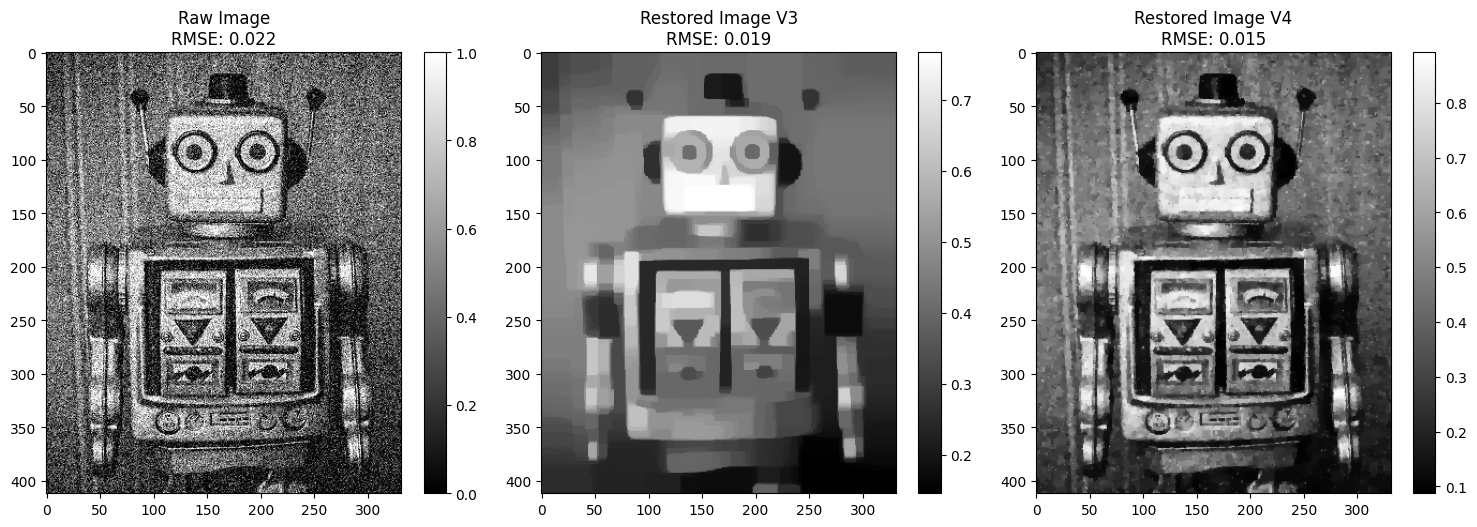

In [11]:
# Display the raw image and RMSE values for comparison
plt.figure(figsize=(15, 5))

# Display the raw noisy image
plt.subplot(1, 3, 1)
plt.imshow(u_b, cmap='gray')
plt.title(f'Raw Image\nRMSE: {RMSE(u_b):.3f}')
plt.colorbar()

# Display the first restored image
plt.subplot(1, 3, 2)
plt.imshow(u_rest_3, cmap='gray')
plt.title(f'Restored Image V3\nRMSE: {RMSE(u_rest_3):.3f}')
plt.colorbar()

# Display the second restored image
plt.subplot(1, 3, 3)
plt.imshow(u_rest_4, cmap='gray')
plt.title(f'Restored Image V4\nRMSE: {RMSE(u_rest_4):.3f}')
plt.colorbar()

plt.tight_layout()
plt.show()

Pour trouver un équilibre entre régularité et fidélité à l'image initiale. On pourrait ajouter un poids devant les termes de TVL2 et les adapter pour obtenir le résultat souhaité. 